<a href="https://colab.research.google.com/github/chippyzhou/pytorch-learning/blob/main/Lab1_Simple_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

100%|██████████| 170M/170M [00:04<00:00, 41.0MB/s]


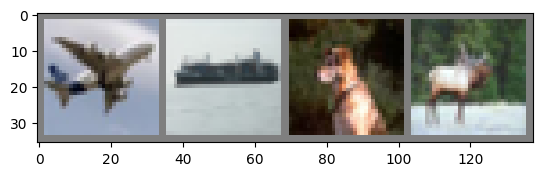

plane ship  dog   deer 
12500
[1,  2000] loss: 2.167
[1,  4000] loss: 1.831
[1,  6000] loss: 1.682
[1,  8000] loss: 1.594
[1, 10000] loss: 1.527
[1, 12000] loss: 1.482
[2,  2000] loss: 1.433
[2,  4000] loss: 1.393
[2,  6000] loss: 1.349
[2,  8000] loss: 1.346
[2, 10000] loss: 1.352
[2, 12000] loss: 1.293
Finished Training


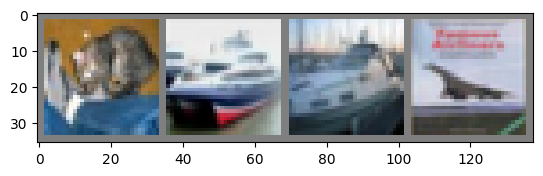

GroundTruth:  cat   ship  ship  plane
Predicted:  cat   ship  ship  plane
Accuracy of the network on the 10000 test images: 53 %
Accuracy for class: plane is 64.7 %
Accuracy for class: car   is 38.6 %
Accuracy for class: bird  is 32.2 %
Accuracy for class: cat   is 43.6 %
Accuracy for class: deer  is 50.1 %
Accuracy for class: dog   is 46.6 %
Accuracy for class: frog  is 67.8 %
Accuracy for class: horse is 59.5 %
Accuracy for class: ship  is 54.9 %
Accuracy for class: truck is 81.5 %


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# ⚠️data loading

transform = transforms.Compose(
    [transforms.ToTensor(), # 归一化 把图片数据变成-1到1的浮点值
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def show(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
show(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

# ⚠️define neural network

class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3,6,5) # input channel output kernel
    self.pool = nn.MaxPool2d(2,2) # kernel(2*2) step 2
    self.conv2 = nn.Conv2d(6,16,5)
    self.fc1 = nn.Linear(16*5*5, 120)
    self.fc2 = nn.Linear(120,84)
    self.fc3 = nn.Linear(84,10)

  def forward(self,x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = torch.flatten(x,1)
    x = F.relu(self.fc1(x)) # relu的作用是把负数归0
    x = F.relu(self.fc2(x)) # 中间用relu可以降噪，但是最后用就会影响结果
    x = self.fc3(x)
    return x

net = Net()
net.to(device)

# ⚠️define loss and optimize function

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# ⚠️train the network

total_steps = len(trainloader)
print(total_steps)

for epoch in range(2):
  running_loss = 0.0

  for i,data in enumerate(trainloader,0):
    inputs, labels = data[0].to(device), data[1].to(device) # inputs
    optimizer.zero_grad()

    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    if i % 2000 == 1999:
      print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
      running_loss = 0.0

print('Finished Training')

PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

# ⚠️test

dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
show(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

net = Net()
net.load_state_dict(torch.load(PATH, weights_only=True))
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

In [ ]:
import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0
